In [1]:
import pandas as pd
import numpy as np
from scipy.stats import kurtosis
from scipy.stats import skew

In [10]:
import sys
!{sys.executable} -m pip install --user matplotlib_venn

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
from scipy.stats import anderson
from scipy.stats import kstest
from scipy.stats import shapiro

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def kurt(values,n,sample_mean, sample_std):
    result=np.sum(((values-sample_mean)/sample_std)**4)*n*(n+1)/((n-1)*(n-2)*(n-3))-3*(n-1)**2/((n-2)*(n-3))
    return(result)

def skewness(values,n,sample_mean, sample_std):
    result=n*np.sum(((values-sample_mean)/sample_std)**3)/((n-1)*(n-2))
    return(result)

def CV(sample_mean,sample_std):
    return(100*sample_std/sample_mean)

#Data processing for APPX-035726(aranesp):
1. Exclude non-numeric parameters
2. Exclude parameters with less than 30 lots
3. Exclude parameters with less than 5 levels of values
4. Do not calculate ppk for parameters without specs; include them in the output table and compute normality stats for them
5. Exclude one lot: 0010390991(remove immunoassay only)
   0010353105(remove all parameter, this has been addressed before generating this APPX, no records left)

In [5]:
#read in dataset
aranesp=pd.read_excel("query-impala-154041.xlsx")

print(aranesp.shape)
#aranesp.columns

(6110, 37)


test anderson output
anderson([1,2,312,314,2341,39,22])

In [6]:
(aranesp["batch number"]!=aranesp["run number"]).any()
#run number is the same as batch number, INT format

False

Type of Specs: str(.) for missing/non-existing specs, INT for existing specs

In [7]:
#Lists of parameters, limit to quantitative params
para_uniq=list(pd.unique(aranesp['parameter name']))
unit_uniq=list(pd.unique(aranesp['unit procedure']))
#could generate unit_uniq after limiting to quantitative only, should not matter
qualitative_paras=list(pd.unique(aranesp["parameter name"][aranesp['result type']=="TEXT"]))

quantitative_paras=list(pd.unique(aranesp["parameter name"][aranesp['result type']=="Number"]))

set(quantitative_paras)==set(para_uniq)-set(qualitative_paras)

len(quantitative_paras)
31 numeric params in this dataset

set(aranesp['result type'])
{'Number', 'TEXT'} #pay attention to the capitalization

In [8]:
#exclude 10390991's immunoassay
aranesp=aranesp[~((aranesp["batch number"]==10390991)&(aranesp["parameter name"]=="Immunoassay"))]
print(aranesp.shape)

(6109, 37)


In [11]:
aranesp.columns

Index(['unit procedure', 'sampling point', 'parameter name',
       'parameter detail', 'run number', 'batch number', 'date of manufacture',
       'process start', 'parameter date', 'local id', 'value_text(reported)',
       'value_num(recorded/full precision)', 'uom', 'lal', 'ual', 'lcl', 'ucl',
       'lrl', 'ucl.1', 'cl', 'nel1', 'nel2', 'nel3', 'nel4', 'ppk', 'rep',
       'control_precision', 'action_precision', 'rejection_precision', 'scale',
       'summary table', 'disposition_date', 'result type', 'source_system',
       'ctrl_violation', 'action_violation', 'rej_violation'],
      dtype='object')

In [9]:
aranesp_quan=aranesp[aranesp["parameter name"].isin(quantitative_paras)]
#update on Oct 4: limit the raw data to quantitative parameters only

In [10]:
#do ppk for the quan dataset first or do it in the loop below()
#if do ppk first, the std may be zero for params with 1 value/row-->error
#ppk needs mean and std, cant avoid loop anyway, just generate spec status first

TBD: if elseif in one line
    if pass a df to a function changes the df outside the function(yes, the original df would be changed once it is passed to this function---->use a COPY if needed

In [11]:
#update on Oct 8: valid function to give indicator for each row. not that useful. 
#Use this for the output dataset(aggregate variables, each parameter is assigned a row)
def add_specside(df):
    #no spec default
    df["Spec Status"]=None
    #two specs
    df["Spec Status"].loc[(df.UAL!=".") & (df.LAL!=".")]=0
    #only lower spec
    df["Spec Status"].loc[(df.UAL==".") & (df.LAL!=".")]=-1
    #only upper spec
    df["Spec Status"].loc[(df.UAL!=".") & (df.LAL==".")]=1
    
    #return(df)

-1

In [1]:
def singlerow_specstatus(lal, ual):
    spec_status=None
    #two specs
    if ((ual!=".")&(lal!=".")):
        spec_status=0
    #only lower spec
    if (ual==".")&(lal!="."):
        spec_status=-1
    if (ual!=".")&(lal=="."):
        spec_status=1

    
    return(spec_status)

In [12]:
n_attributes=len(quantitative_paras)*len(pd.unique(aranesp['unit procedure']))

n_stats=6 
# 6 stats for normality assessment

In [13]:
n_attributes

403

In [82]:
#output df initiation
nor_stats_output_all=pd.DataFrame(columns=["Parameter Name",'Unit Procedure',#"PRDS",#\
                                           "N","Mean","Median","STD","UAL","LAL","Spec Status","Ppk",\
                                           "Skewness","Kurtosis","CV","Anderson-Darling","Shapiro","KS"])


In [83]:
nor_stats_output_all

,Parameter Name,Unit Procedure,N,Mean,Median,STD,UAL,LAL,Spec Status,Ppk,Skewness,Kurtosis,CV,Anderson-Darling,Shapiro,KS


valid for all rows in this dataset:
parameter data=manu date
process start<=date of manu

In [84]:
for para in quantitative_paras:
    for unit in unit_uniq:
        single_df=aranesp_quan[(aranesp_quan['unit procedure']==unit)&
                                              (aranesp_quan['parameter name']==para)].copy()
        sub_df=single_df["value_num(recorded/full precision)"]      

        if (len(sub_df)>=30):
            if len(pd.unique(sub_df)>=5):
                #prds=pd.unique(single_df["parameter detail"])
                ual=single_df.sort_values(by="parameter date").ual.iloc[-1]
                lal=single_df.sort_values(by="parameter date").lal.iloc[-1]
                spec_status=singlerow_specstatus(lal,ual)
                
                nor_stats_output_all=nor_stats_output_all.append({\
                        'Parameter Name':para,\
                        "Unit Procedure":unit,\
                        #"PRDS":prds,
                        "N":len(sub_df),\
                        "Mean":np.mean(sub_df),\
                        "STD":np.std(sub_df,ddof=1),\
                        "Median":np.median(sub_df),\
                        "LAL":lal, "UAL":ual,      \
                        "Spec Status":spec_status ,\
                        "Ppk": ppk_single_row(sub_df,ual,lal,spec_status),\
                        "Skewness":skewness(sub_df,len(sub_df),np.mean(sub_df),np.std(sub_df,ddof=1)),\
                        "Kurtosis":kurt(sub_df,len(sub_df),np.mean(sub_df),np.std(sub_df,ddof=1)),\
                        "CV":CV(np.mean(sub_df),np.std(sub_df,ddof=1)),\
                        #"Anderson-Darling":anderson(sub_df),\
                        "Shapiro":shapiro(sub_df)[1],\
                        #the p value of shapiro
                        "KS":kstest(sub_df,"norm")[1]},\
                        #the p value of kstest
                                    ignore_index=True)

In [86]:
nor_stats_output_all.sort_values(by=["Unit Procedure","Parameter Name"]).reset_index(drop=True)

,Parameter Name,Unit Procedure,N,Mean,Median,STD,UAL,LAL,Spec Status,Ppk,Skewness,Kurtosis,CV,Anderson-Darling,Shapiro,KS
0,Chloride,IEDL:ADL9-DP-ADL,50,138.662200,138.485000,1.696981,170,110,0,5.63004,1.105692,3.662593,1.223824,NaN,2.289855e-03,0.000000e+00
1,Immunoassay,IEDL:ADL9-DP-ADL,57,1.031193,1.023500,0.053303,1.2,0.8,0,1.05564,0.331360,-0.327343,5.169090,NaN,7.188891e-01,0.000000e+00
2,In vitro bioassay,IEDL:ADL9-DP-ADL,50,104.400000,104.500000,6.077728,123,78,0,1.02012,-0.041020,1.787548,5.821578,NaN,8.635213e-02,0.000000e+00
3,Methionine Oxidation,IEDL:ADL9-DP-ADL,50,1.321600,1.325000,0.147196,4,.,1,6.06537,-0.067031,-0.043242,11.137741,NaN,9.741972e-01,0.000000e+00
4,Phosphate,IEDL:ADL9-DP-ADL,50,19.904980,19.885500,0.265579,24,16,0,4.90122,0.299120,0.480663,1.334233,NaN,6.419759e-01,0.000000e+00
5,Polysorbate 80,IEDL:ADL9-DP-ADL,57,0.004544,0.004500,0.000348,0.007,0.003,0,1.47895,0.070300,-0.644668,7.657855,NaN,3.491033e-01,8.637535e-14
6,SE-HPLC,IEDL:ADL9-DP-ADL,50,99.972880,99.973000,0.002819,.,99.5,-1,11823,-0.134594,0.368606,0.002819,NaN,2.752670e-01,0.000000e+00
7,Subvisible Particles >= 10 um,IEDL:ADL9-DP-ADL,50,109.054000,42.810000,151.458606,6000,.,1,12.9649,2.959013,10.058229,138.884045,NaN,2.261463e-10,0.000000e+00
8,Subvisible Particles >= 25 um,IEDL:ADL9-DP-ADL,50,1.175400,0.370000,1.820657,600,.,1,109.635,2.902401,9.641608,154.896819,NaN,3.174999e-10,1.106670e-12
9,pH,IEDL:ADL9-DP-ADL,43,6.182093,6.180000,0.024354,6.4,6,0,2.49227,-0.068828,-0.301466,0.393950,NaN,5.954637e-01,0.000000e+00


In [42]:
results

,Unnamed: 0,Parameter Name,Unit Procedure,PRDS,N,Mean,STD,UAL,LAL,Ppk,Skewness,Kurtosis,CV,Anderson-Darling,Shapiro,KS,Spec Status
0,0,Chloride,IEDL:ADL9-DP-ADL,PRDS-000444,50,138.662200,1.696981,170,110,5.630038,1.105692,3.662593,1.223824,NaN,2.289855e-03,0.000000e+00,0.0
1,6,Immunoassay,IEDL:ADL9-DP-ADL,PRDS-000452,57,1.031193,0.053303,1.2,0.8,1.055639,0.331360,-0.327343,5.169090,NaN,7.188891e-01,0.000000e+00,0.0
2,12,In vitro bioassay,IEDL:ADL9-DP-ADL,PRDS-000444,50,104.400000,6.077728,123,78,1.020118,-0.041020,1.787548,5.821578,NaN,8.635213e-02,0.000000e+00,0.0
3,18,Methionine Oxidation,IEDL:ADL9-DP-ADL,PRDS-000444,50,1.321600,0.147196,4,.,6.065366,-0.067031,-0.043242,11.137741,NaN,9.741972e-01,0.000000e+00,1.0
4,24,Phosphate,IEDL:ADL9-DP-ADL,PRDS-000444,50,19.904980,0.265579,24,16,4.901221,0.299120,0.480663,1.334233,NaN,6.419759e-01,0.000000e+00,0.0
5,30,Polysorbate 80,IEDL:ADL9-DP-ADL,PRDS-000452,57,0.004544,0.000348,0.007,0.003,1.478953,0.070300,-0.644668,7.657855,NaN,3.491033e-01,8.637535e-14,0.0
6,36,SE-HPLC,IEDL:ADL9-DP-ADL,PRDS-000444,50,99.972880,0.002819,.,99.5,55.923802,-0.134594,0.368606,0.002819,NaN,2.752670e-01,0.000000e+00,-1.0
7,42,Subvisible Particles >= 10 um,IEDL:ADL9-DP-ADL,PRDS-000444,50,109.054000,151.458606,6000,.,12.964920,2.959013,10.058229,138.884045,NaN,2.261463e-10,0.000000e+00,1.0
8,48,Subvisible Particles >= 25 um,IEDL:ADL9-DP-ADL,PRDS-000444,50,1.175400,1.820657,600,.,109.635245,2.902401,9.641608,154.896819,NaN,3.174999e-10,1.106670e-12,1.0
9,66,pH,IEDL:ADL9-DP-ADL,PRDS-000444,43,6.182093,0.024354,6.4,6,2.492273,-0.068828,-0.301466,0.393950,NaN,5.954637e-01,0.000000e+00,0.0


### compute ppk for a dataframe, no longer in use if the spec_status is not correct-->change to ppk calculation for a single line
def ppk_compute(df):
    #for two-sided specs
    df["Ppk"].loc[df["Spec Status"]==0]=pd.DataFrame.min\
        (pd.concat([df.UAL.loc[df["Spec Status"]==0]-df.Mean.loc[df["Spec Status"]==0],\
                    df.Mean.loc[df["Spec Status"]==0]-df.LAL.loc[df["Spec Status"]==0]],axis=1),axis=1)/(3*df.STD)
    #for upper spec only
    df["Ppk"].loc[df["Spec Status"]==1]=(df.UAL.loc[df["Spec Status"]==1]-df.Mean.loc[df["Spec Status"]==1])/(3*df.STD)
    #for lower spec only
    df["Ppk"].loc[df["Spec Status"]==-1]=(df.Mean.loc[df["Spec Status"]==-1]-df.LAL.loc[df["Spec Status"]==-1])/(3*df.STD)
    #return(df)

In [178]:
#add this column to the entire output table(all params), compute power regardless of normality compliance
def power_compute(df):
    df["Power"]=None
    #right-skewed, positive power
    df["Power"].loc[df["Skewness"]>0]=(df["Mean"]-df["Median"])/df["STD"]
    #left-skewed, negative power
    df["Power"].loc[df["Skewness"]<0]=(df["Mean"]-df["Median"])*df["Mean"]/df["STD"]

In [81]:
def ppk_single_row(values,ual,lal,spec_status):
    if spec_status==0:
        ppk=np.minimum(ual-np.mean(values),np.mean(values)-lal )/(3*np.std(values,ddof=1))
    else:
        if spec_status==1:
            ppk=(ual-np.mean(values))/(3*np.std(values,ddof=1))
        else:
            if spec_status==-1:
                ppk=(np.mean(values)-lal)/(3*np.std(values,ddof=1))
            else:
                ppk=None
    return(ppk)
    

In [176]:
ppk_compute(nor_stats_output_all)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [179]:
power_compute(nor_stats_output_all)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [194]:
nor_stats_output_all=nor_stats_output_all.sort_values(by=["Unit Procedure","Parameter Name"]).reset_index(drop=True)

#test case
nor_stats_output_all[(nor_stats_output_all["Unit Procedure"]=="IEDL:ADL9-DP-ADL")&\
                     (nor_stats_output_all["Parameter Name"]=="In vitro bioassay")]

In [136]:
nor_stats_output_all.to_csv("normal_stats_output_all_Oct5.csv")


In [19]:
results=pd.read_csv("normal_stats_output_all_Oct5.csv")

In [88]:
(nor_stats_output_all["Kurtosis"].describe())
nor_stats_output_all["Skewness"].describe()

count    89.000000
mean      2.394802
std       5.370275
min      -1.636082
25%      -0.398523
50%       0.428002
75%       2.791818
max      29.999852
Name: Kurtosis, dtype: float64

(array([58., 19.,  3.,  4.,  1.,  2.,  0.,  0.,  0.,  2.]),
 array([-1.63608157,  1.52751181,  4.69110518,  7.85469856, 11.01829193,
        14.18188531, 17.34547868, 20.50907206, 23.67266543, 26.83625881,
        29.99985218]),
 <a list of 10 Patch objects>)

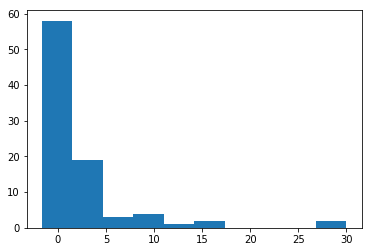

In [87]:
plt.hist(nor_stats_output_all["Kurtosis"])

In [137]:
#screening thresholds:
skew_limit=[-1,1]
kurt_limit=2
#cv_limit=0
#ks_limit=0.05
#shapiro_limit=0.05


In [138]:
non_normal_skew=nor_stats_output_all[(nor_stats_output_all["Skewness"]<skew_limit[0])|\
                    (nor_stats_output_all["Skewness"]>skew_limit[1])]
non_normal_skew.to_csv("Non_normal_skew_aranesp.csv")

In [139]:
non_normal_kurt=nor_stats_output_all[nor_stats_output_all["Kurtosis"]>kurt_limit]
non_normal_kurt.to_csv("Non_normal_kurt_aranesp.csv")
#28 detected by skew, 25 detected by kurt

In [189]:
non_normal_skew_or_kurt=nor_stats_output_all[(nor_stats_output_all["Skewness"]<skew_limit[0])|\
                    ((nor_stats_output_all["Skewness"]>skew_limit[1])|\
                                            (nor_stats_output_all["Kurtosis"]>kurt_limit))]

In [197]:
#useful info after trans: any improvement on normal stats, PPK
non_normal_skew_or_kurt["Ppk_Transed"]=None
#non_normal_skew_or_kurt["Mean_Transed"]=None
#non_normal_skew_or_kurt["STD_Transed"]=None
non_normal_skew_or_kurt["Skewness_Transed"]=None
non_normal_skew_or_kurt["Kurtosis_Transed"]=None
non_normal_skew_or_kurt["UAL_Transed"]=None
non_normal_skew_or_kurt["LAL_Transed"]=None

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vie

In [228]:
non_normal_skew_or_kurt

,Parameter Name,Unit Procedure,PRDS,N,Mean,Median,STD,UAL,LAL,Ppk,...,Anderson-Darling,Shapiro,KS,Spec Status,Power,Ppk_Transed,Skewness_Transed,Kurtosis_Transed,UAL_Transed,LAL_Transed
0,Chloride,IEDL:ADL9-DP-ADL,"[PRDS-000444, PRDS-000443, PRDS-000449, PRDS-0...",50,138.662200,138.48500,1.696981,170,110,5.63004,...,NaN,2.289855e-03,0.000000e+00,0,0.104421,None,1.03874,3.46707,1.70964,1.63367
42,Subvisible Particles >= 10 um,IEDL:ADL9-DP-ADL,"[PRDS-000444, PRDS-000443, PRDS-000449, PRDS-0...",50,109.054000,42.81000,151.458606,6000,.,12.9649,...,NaN,2.261463e-10,0.000000e+00,1,0.437374,None,None,None,None,None
48,Subvisible Particles >= 25 um,IEDL:ADL9-DP-ADL,"[PRDS-000444, PRDS-000443, PRDS-000449, PRDS-0...",50,1.175400,0.37000,1.820657,600,.,109.635,...,NaN,3.174999e-10,1.106670e-12,1,0.442368,None,None,None,None,None
43,Subvisible Particles >= 10 um,PRJU:APR1-DP-ADL,"[PRDS-000436, PRDS-000674, PRDS-000438, PRDS-0...",30,178.055333,131.01500,152.530761,6000,.,12.723,...,NaN,2.071484e-05,0.000000e+00,1,0.308399,None,None,None,None,None
49,Subvisible Particles >= 25 um,PRJU:APR1-DP-ADL,"[PRDS-000436, PRDS-000674, PRDS-000438, PRDS-0...",30,1.457667,0.89500,1.640645,600,.,121.607,...,NaN,5.606328e-07,1.723327e-09,1,0.342955,None,None,None,None,None
20,Methionine Oxidation,PRJU:APR1-DP-AML,"[PRDS-000672, PRDS-000560, PRDS-000443, PRDS-0...",30,1.376333,1.29000,0.275149,4,.,3.17848,...,NaN,3.262040e-05,0.000000e+00,1,0.31377,None,None,None,None,None
38,SE-HPLC,PRJU:APR1-DP-AML,"[PRDS-000452, PRDS-000444, PRDS-000439, PRDS-0...",30,99.974000,99.97800,0.015541,.,99.5,10.1668,...,NaN,3.304073e-08,0.000000e+00,-1,-25.732,None,None,None,None,None
59,Volume (0.4 mL Syringe),PRJU:APR1-DP-AML,"[PRDS-000452, PRDS-000444, PRDS-000672, PRDS-0...",30,0.426460,0.42610,0.002866,.,0.4,3.07703,...,NaN,4.693679e-02,1.694200e-13,-1,0.125593,None,None,None,None,None
75,Volume (1.0 mL Syringe),PRJU:APR1-DP-AML,[PRDS-000560],30,1.042125,1.04390,0.005130,.,1,2.73734,...,NaN,3.217035e-02,0.000000e+00,-1,-0.360673,None,None,None,None,None
68,pH,PRJU:APR1-DP-AML,"[PRDS-000443, PRDS-000449, PRDS-000436, PRDS-0...",30,6.198667,6.20000,0.028616,6.4,6,2.3142,...,NaN,1.376330e-03,0.000000e+00,0,-0.0465947,None,None,None,None,None


In [232]:
for i in range(len(non_normal_skew_or_kurt)):
    para=non_normal_skew_or_kurt["Parameter Name"].iloc[i]
    unit=non_normal_skew_or_kurt["Unit Procedure"].iloc[i]
    power=non_normal_skew_or_kurt["Power"].iloc[i]
    spec=non_normal_skew_or_kurt["Spec Status"].iloc[i]
    
    single_df=aranesp_quan[(aranesp_quan['unit procedure']==unit)&
                                              (aranesp_quan['parameter name']==para)]
    values=single_df["value_num(recorded/full precision)"]      
    transed_values=values**power
    non_normal_skew_or_kurt["Skewness_Transed"].iloc[i]=skewness(transed_values,\
                            len(transed_values),np.mean(transed_values),np.std(transed_values,ddof=1))
    non_normal_skew_or_kurt["Kurtosis_Transed"].iloc[i]=kurt(transed_values,len(transed_values),\
                                                np.mean(transed_values),np.std(transed_values,ddof=1))
    if spec==0:
        non_normal_skew_or_kurt["UAL_Transed"].iloc[i]=non_normal_skew_or_kurt["UAL"].iloc[i]**power
        non_normal_skew_or_kurt["LAL_Transed"].iloc[i]=non_normal_skew_or_kurt["LAL"].iloc[i]**power
    else:
        if spec==1:
            non_normal_skew_or_kurt["UAL_Transed"].iloc[i]=non_normal_skew_or_kurt["UAL"].iloc[i]**power
        if spec==-1:
            non_normal_skew_or_kurt["LAL_Transed"].iloc[i]=non_normal_skew_or_kurt["LAL"].iloc[i]**power
    
    ppk_transed=ppk_single_row(transed_values,\
                              non_normal_skew_or_kurt["UAL_Transed"].iloc[i],\
                              non_normal_skew_or_kurt["LAL_Transed"].iloc[i],\
                              spec)          
    non_normal_skew_or_kurt["Ppk_Transed"].iloc[i]=ppk_transed

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-pac

In [233]:
non_normal_skew_or_kurt[["Skewness","Skewness_Transed","Kurtosis","Kurtosis_Transed","Ppk","Ppk_Transed",]]

,Skewness,Skewness_Transed,Kurtosis,Kurtosis_Transed,Ppk,Ppk_Transed
0,1.105692,1.03874,3.662593,3.46707,5.63004,5.699349
42,2.959013,1.70013,10.058229,2.703,12.9649,3.758659
48,2.902401,1.39675,9.641608,1.82175,109.635,9.719276
43,1.992077,0.881809,4.208400,0.500214,12.723,3.063945
49,2.603251,1.13737,7.033934,1.71121,121.607,7.911496
20,1.588663,1.39998,1.629859,1.19218,3.17848,2.346264
38,-3.634087,3.65294,15.478739,15.6197,10.1668,84.161138
59,1.081501,1.05342,2.791818,2.69859,3.07703,402.784976
75,-1.059772,1.08102,1.461731,1.5403,2.73734,190.326760
68,1.628857,-1.60497,4.502085,4.40347,2.3142,-2.402023


### 28 detected by skew, 25 detected by kurtosis, 30 in total, 23 overlapped
### the positivity of skewness does not quite relate to if the sideness of specs

In [157]:
len(set(non_normal_skew.index).union(set(non_normal_kurt.index)))
len(set(non_normal_skew.index).intersection(set(non_normal_kurt.index)))
len(non_normal_skew)
len(non_normal_kurt)

25

In [236]:
#single investigation for two low ppk params:
para="Isoelectric Focusing: Isoforms 19 + 20"
unit="PRJU:APR6-DS-AML"
single_df=aranesp_quan[(aranesp_quan['unit procedure']==unit)&
                                              (aranesp_quan['parameter name']==para)]
single_df=single_df[single_df["value_num(recorded/full precision)"]>single_df.lal]

TypeError: '>' not supported between instances of 'float' and 'str'

In [234]:
non_normal_skew_or_kurt.sort_values(by="Ppk")

,Parameter Name,Unit Procedure,PRDS,N,Mean,Median,STD,UAL,LAL,Ppk,...,Anderson-Darling,Shapiro,KS,Spec Status,Power,Ppk_Transed,Skewness_Transed,Kurtosis_Transed,UAL_Transed,LAL_Transed
85,Isoelectric Focusing: Isoforms 19 + 20,PRJU:APR6-DS-AML,[PRDS-000418],30,26.293750,25.84900,6.198589,.,43,-0.89839,...,NaN,1.762701e-02,0.000000e+00,-1,0.0717502,21.059149,0.307716,1.54625,None,1.30979
83,Isoelectric Focusing: Isoform 21 + 22,PRJU:APR6-DS-AML,[PRDS-000418],30,73.627033,74.15050,6.495626,91,54,0.891521,...,NaN,3.459311e-03,0.000000e+00,0,-5.93342,-0.947117,5.09157,27.0682,2.37782e-12,5.25987e-11
33,Polysorbate 80,PRJU:APR1-DP-CRL,"[PRDS-000438, PRDS-000439, PRDS-000433, PRDS-0...",30,0.004607,0.00460,0.000322,0.007,0.003,1.66548,...,NaN,4.423061e-02,1.668479e-07,0,0.0207321,2.032645,-0.424652,3.04378,0.902245,0.886534
76,Volume (1.0 mL Syringe),PRJU:APR1-DP-CRL,[PRDS-000560],30,1.042727,1.04310,0.007942,.,1,1.79337,...,NaN,2.870865e-07,0.000000e+00,-1,-0.0490184,896.081745,3.55741,16.3811,None,1
81,Carbohydrate Profile (sialo) oligosaccharide m...,PRJU:APR6-DS-AML,[PRDS-000418],30,3.759667,3.76700,0.023360,3.89,3.61,1.8598,...,NaN,4.446966e-05,0.000000e+00,0,-1.18027,-2.233658,2.45743,9.1614,0.201233,0.219781
72,pH,PRJU:APR6-DS-AML,[PRDS-000418],30,6.050267,6.06000,0.041997,6.3,5.7,1.98213,...,NaN,1.601090e-04,0.000000e+00,0,-1.40221,-2.989221,1.97427,4.96005,0.0757107,0.0871175
68,pH,PRJU:APR1-DP-AML,"[PRDS-000443, PRDS-000449, PRDS-000436, PRDS-0...",30,6.198667,6.20000,0.028616,6.4,6,2.3142,...,NaN,1.376330e-03,0.000000e+00,0,-0.0465947,-2.402023,-1.60497,4.40347,0.917141,0.919904
75,Volume (1.0 mL Syringe),PRJU:APR1-DP-AML,[PRDS-000560],30,1.042125,1.04390,0.005130,.,1,2.73734,...,NaN,3.217035e-02,0.000000e+00,-1,-0.360673,190.326760,1.08102,1.5403,None,1
57,Volume (0.3 mL Syringe),PRJU:APR14-DP-ADL,"[PRDS-000443, PRDS-000433, PRDS-000436]",36,0.335139,0.33495,0.004013,.,0.3,2.9185,...,NaN,7.620749e-07,2.531308e-14,-1,0.0470651,609.216944,2.89716,13.4983,None,0.94491
59,Volume (0.4 mL Syringe),PRJU:APR1-DP-AML,"[PRDS-000452, PRDS-000444, PRDS-000672, PRDS-0...",30,0.426460,0.42610,0.002866,.,0.4,3.07703,...,NaN,4.693679e-02,1.694200e-13,-1,0.125593,402.784976,1.05342,2.69859,None,0.891295


'Series' objects are mutable, thus they cannot be hashed


In [1]:
import matplotlib

In [9]:
 

%matplotlib inline
import matplotlib_venn as vplt
from matplotlib import pyplot as plt

v=vplt.venn2(subsets={'10':10, '01' :1, '11' : 1}, set_labels=('A','B'))
plt.show()


ModuleNotFoundError: No module named 'matplotlib_venn'

In [7]:
%matplotlib inline
import matplotlib_venn as vplt
from matplotlib import pyplot as plt

ModuleNotFoundError: No module named 'matplotlib_venn'

In [2]:
from matplotlib_venn._venn3 import venn3, venn3_circles

ModuleNotFoundError: No module named 'matplotlib_venn'

In [143]:
from matplotlib_venn import venn3, venn3_circles

ModuleNotFoundError: No module named 'matplotlib_venn'